# Small CNN (Computationally inexpensive)

In [2]:
"""
Lightweight CIFAR-10 training script (PyTorch)
- Small CNN (much faster than ResNet18)
- Runs comfortably on CPU/GPU in <15 min
"""

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
import numpy as np
import random, os, time

# ------------------------- Config -------------------------
SEED = 42
BATCH_SIZE = 64
NUM_WORKERS = 2
EPOCHS = 10
LR = 0.001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_DIR = "checkpoints"
os.makedirs(MODEL_DIR, exist_ok=True)

def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

seed_everything()

# ------------------------- Data -------------------------
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

train_tfms = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

test_tfms = T.Compose([
    T.ToTensor(),
    T.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

train_ds = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tfms)
test_ds  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tfms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# ------------------------- Model -------------------------
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 32x16x16
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 64x8x8
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d(1)  # 128x1x1
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

model = SmallCNN().to(DEVICE)

# ------------------------- Training -------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

def evaluate(model, loader):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
            out = model(imgs)
            loss = criterion(out, labels)
            _, preds = out.max(1)
            correct += preds.eq(labels).sum().item()
            loss_sum += loss.item() * imgs.size(0)
            total += imgs.size(0)
    return loss_sum/total, correct/total

best_acc = 0
for epoch in range(1, EPOCHS+1):
    start = time.time()
    model.train()
    running_loss, total, correct = 0, 0, 0

    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = out.max(1)
        correct += preds.eq(labels).sum().item()
        total += imgs.size(0)

        if i % 100 == 0:
            print(f"Epoch {epoch} [{i*BATCH_SIZE}/{len(train_loader.dataset)}] "
                  f"Loss: {loss.item():.4f}")

    train_loss = running_loss / total
    train_acc = correct / total
    val_loss, val_acc = evaluate(model, test_loader)

    print(f"Epoch {epoch}: TrainAcc={train_acc:.4f}, ValAcc={val_acc:.4f}, Time={time.time()-start:.1f}s")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), os.path.join(MODEL_DIR, "smallcnn_cifar10.pth"))
        print(f"✅ Saved best model (ValAcc={val_acc:.4f})")

print(f"Training done. Best ValAcc={best_acc:.4f}")


Epoch 1 [0/50000] Loss: 2.3013
Epoch 1 [6400/50000] Loss: 2.0912
Epoch 1 [12800/50000] Loss: 1.9826
Epoch 1 [19200/50000] Loss: 1.8172
Epoch 1 [25600/50000] Loss: 1.7005
Epoch 1 [32000/50000] Loss: 1.8577
Epoch 1 [38400/50000] Loss: 1.6346
Epoch 1 [44800/50000] Loss: 1.6689
Epoch 1: TrainAcc=0.3181, ValAcc=0.4098, Time=92.1s
✅ Saved best model (ValAcc=0.4098)
Epoch 2 [0/50000] Loss: 1.7934
Epoch 2 [6400/50000] Loss: 1.5170
Epoch 2 [12800/50000] Loss: 1.7039
Epoch 2 [19200/50000] Loss: 1.3973
Epoch 2 [25600/50000] Loss: 1.4770
Epoch 2 [32000/50000] Loss: 1.5768
Epoch 2 [38400/50000] Loss: 1.3087
Epoch 2 [44800/50000] Loss: 1.5755
Epoch 2: TrainAcc=0.4457, ValAcc=0.4877, Time=80.7s
✅ Saved best model (ValAcc=0.4877)
Epoch 3 [0/50000] Loss: 1.5164
Epoch 3 [6400/50000] Loss: 1.2844
Epoch 3 [12800/50000] Loss: 1.3000
Epoch 3 [19200/50000] Loss: 1.3196
Epoch 3 [25600/50000] Loss: 1.6148
Epoch 3 [32000/50000] Loss: 1.4733
Epoch 3 [38400/50000] Loss: 1.4489
Epoch 3 [44800/50000] Loss: 1.3878
E

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# --- Device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- CIFAR-10 test data ---
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

transform = T.Compose([
    T.ToTensor(),
    T.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False)

# --- Define SAME model as in training ---
class SmallCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# --- Load trained weights ---
model = SmallCNN().to(device)
model.load_state_dict(torch.load("checkpoints/smallcnn_cifar10.pth", map_location=device))
model.eval()

# --- Evaluate ---
correct, total = 0, 0
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

accuracy = 100 * correct / total
print(f"✅ Test Accuracy: {accuracy:.2f}% ({correct}/{total})")

# --- Detailed metrics ---
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=testset.classes))

print("\nConfusion Matrix:")
print(confusion_matrix(y_true, y_pred))


✅ Test Accuracy: 66.22% (6622/10000)

Classification Report:
              precision    recall  f1-score   support

    airplane       0.70      0.72      0.71      1000
  automobile       0.79      0.83      0.81      1000
        bird       0.58      0.41      0.48      1000
         cat       0.46      0.43      0.44      1000
        deer       0.70      0.47      0.56      1000
         dog       0.50      0.73      0.60      1000
        frog       0.61      0.79      0.69      1000
       horse       0.78      0.66      0.72      1000
        ship       0.76      0.82      0.79      1000
       truck       0.81      0.76      0.79      1000

    accuracy                           0.66     10000
   macro avg       0.67      0.66      0.66     10000
weighted avg       0.67      0.66      0.66     10000


Confusion Matrix:
[[717  32  46  15   7  18  13  11 115  26]
 [ 33 827   6   4   0  14   6   8  25  77]
 [ 93   9 414  93  67 113 163  23  19   6]
 [ 18  13  65 426  16 307  97  2

# Medium CNN

In [ ]:
"""
Medium model CIFAR-10 training (ResNet18 adapted).
- ResNet18 adapted for 32x32 (conv1=3x3, no maxpool)
- RandAugment + RandomCrop/Flip + RandomErasing + Cutout (simple)
- SGD w/ momentum, weight decay; label smoothing
- Cosine LR scheduler; mixed precision (AMP)
- Save best checkpoint by val accuracy
"""

import os, time, random, math
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torch.utils.data import DataLoader
from torchvision.models import resnet18

# -------------------- Config --------------------
SEED = 42
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_DIR = "checkpoints"
os.makedirs(MODEL_DIR, exist_ok=True)

BATCH_SIZE = 128
NUM_WORKERS = 4
EPOCHS = 20                # adjust for faster run
LR = 0.1
MOMENTUM = 0.9
WEIGHT_DECAY = 5e-4
LABEL_SMOOTH = 0.1
T_MAX = EPOCHS             # for CosineAnnealingLR

# -------------------- Repro --------------------
def seed_everything(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
seed_everything()

# -------------------- Transforms --------------------
CIFAR10_MEAN = (0.4914, 0.4822, 0.4465)
CIFAR10_STD  = (0.2470, 0.2435, 0.2616)

train_transforms = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.RandAugment(num_ops=2, magnitude=9),   # light randaugment
    T.ToTensor(),
    T.Normalize(CIFAR10_MEAN, CIFAR10_STD),
    # RandomErasing applied in DataLoader loop (or use transform above if torchvision supports)
])

test_transforms = T.Compose([
    T.ToTensor(),
    T.Normalize(CIFAR10_MEAN, CIFAR10_STD),
])

# -------------------- Datasets / Loaders --------------------
train_ds = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=train_transforms)
test_ds  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=test_transforms)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

# -------------------- Model (ResNet18 adapted) --------------------
def get_resnet18_cifar(num_classes=10, pretrained=False):
    model = resnet18(pretrained=pretrained)
    # adapt first conv for 32x32 input and remove maxpool
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

model = get_resnet18_cifar().to(DEVICE)

# -------------------- Loss, Optimizer, Scheduler --------------------
# CrossEntropy with label smoothing (PyTorch >=1.10 supports label_smoothing)
try:
    criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTH)
except TypeError:
    # fallback: vanilla CrossEntropyLoss (no smoothing)
    criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY, nesterov=True)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_MAX)

# -------------------- Utilities --------------------
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

def accuracy_from_logits(logits, labels):
    preds = logits.argmax(dim=1)
    return (preds == labels).float().mean().item()

# Optional simple Cutout on CPU/GPU tensors
def cutout_tensor(imgs, size=8):
    # imgs: (B,C,H,W) tensor, values assumed normalized already
    B, C, H, W = imgs.size()
    for i in range(B):
        y = random.randint(0, H-1)
        x = random.randint(0, W-1)
        y1 = max(0, y - size//2)
        y2 = min(H, y1 + size)
        x1 = max(0, x - size//2)
        x2 = min(W, x1 + size)
        imgs[i, :, y1:y2, x1:x2] = 0.0
    return imgs

# -------------------- Train / Eval loops --------------------
best_val_acc = 0.0
start_time = time.time()

for epoch in range(1, EPOCHS + 1):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    n = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{EPOCHS} [train]", ncols=120)
    for images, labels in pbar:
        images = images.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        # apply random erasing (PyTorch has transforms.RandomErasing but we can do simple in-batch)
        if random.random() < 0.5:
            images = cutout_tensor(images, size=8)

        optimizer.zero_grad()
        if scaler:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        batch_acc = accuracy_from_logits(outputs, labels)
        running_loss += loss.item() * images.size(0)
        running_acc += batch_acc * images.size(0)
        n += images.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{batch_acc:.4f}")

    train_loss = running_loss / n
    train_acc = running_acc / n

    # validation
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    m = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
            if scaler:
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)
            batch_acc = accuracy_from_logits(outputs, labels)
            val_loss += loss.item() * images.size(0)
            val_acc += batch_acc * images.size(0)
            m += images.size(0)

    val_loss /= m
    val_acc /= m

    # scheduler step
    scheduler.step()

    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch}: TrainLoss={train_loss:.4f}, TrainAcc={train_acc:.4f} | ValLoss={val_loss:.4f}, ValAcc={val_acc:.4f} | Time={epoch_time:.1f}s")

    # checkpoint best
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        ckpt = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'val_acc': val_acc,
        }
        torch.save(ckpt, os.path.join(MODEL_DIR, 'resnet18_cifar10_best.pth'))
        print(f"Saved new best model (val_acc={val_acc:.4f})")

total_time = time.time() - start_time
print(f"Training finished. Best val acc: {best_val_acc:.4f}. Total time: {total_time/60:.1f} min")


Epoch 1/20 [train]: 100%|████████████████████████████████████| 391/391 [28:45<00:00,  4.41s/it, acc=0.2875, loss=1.9469]


Epoch 1: TrainLoss=2.3800, TrainAcc=0.1627 | ValLoss=1.9796, ValAcc=0.2861 | Time=1850.1s
Saved new best model (val_acc=0.2861)


Epoch 2/20 [train]: 100%|████████████████████████████████████| 391/391 [27:54<00:00,  4.28s/it, acc=0.4000, loss=1.8494]


Epoch 2: TrainLoss=1.9048, TrainAcc=0.3272 | ValLoss=1.7207, ValAcc=0.4282 | Time=1793.8s
Saved new best model (val_acc=0.4282)


Epoch 3/20 [train]: 100%|████████████████████████████████████| 391/391 [27:57<00:00,  4.29s/it, acc=0.5375, loss=1.5376]


Epoch 3: TrainLoss=1.6657, TrainAcc=0.4561 | ValLoss=1.4770, ValAcc=0.5523 | Time=1810.2s
Saved new best model (val_acc=0.5523)


Epoch 4/20 [train]: 100%|████████████████████████████████████| 391/391 [28:23<00:00,  4.36s/it, acc=0.5125, loss=1.4699]


Epoch 4: TrainLoss=1.4846, TrainAcc=0.5501 | ValLoss=1.5163, ValAcc=0.5541 | Time=1818.0s
Saved new best model (val_acc=0.5541)


Epoch 5/20 [train]: 100%|████████████████████████████████████| 391/391 [26:48<00:00,  4.11s/it, acc=0.5625, loss=1.4542]


Epoch 5: TrainLoss=1.3524, TrainAcc=0.6146 | ValLoss=1.3188, ValAcc=0.6372 | Time=1724.5s
Saved new best model (val_acc=0.6372)


Epoch 6/20 [train]: 100%|████████████████████████████████████| 391/391 [27:41<00:00,  4.25s/it, acc=0.6625, loss=1.2044]


Epoch 6: TrainLoss=1.2360, TrainAcc=0.6730 | ValLoss=1.2728, ValAcc=0.6814 | Time=1776.1s
Saved new best model (val_acc=0.6814)


Epoch 7/20 [train]: 100%|██████████████████████████████████| 391/391 [9:38:28<00:00, 88.77s/it, acc=0.6875, loss=1.1312]


Epoch 7: TrainLoss=1.1441, TrainAcc=0.7151 | ValLoss=1.1136, ValAcc=0.7307 | Time=34823.3s
Saved new best model (val_acc=0.7307)


Epoch 8/20 [train]: 100%|████████████████████████████████████| 391/391 [28:20<00:00,  4.35s/it, acc=0.7250, loss=1.1704]


Epoch 8: TrainLoss=1.0922, TrainAcc=0.7398 | ValLoss=1.0831, ValAcc=0.7439 | Time=1831.7s
Saved new best model (val_acc=0.7439)


Epoch 9/20 [train]: 100%|████████████████████████████████████| 391/391 [29:18<00:00,  4.50s/it, acc=0.8375, loss=0.8890]


Epoch 9: TrainLoss=1.0399, TrainAcc=0.7639 | ValLoss=0.9799, ValAcc=0.7914 | Time=1899.6s
Saved new best model (val_acc=0.7914)


Epoch 10/20 [train]: 100%|███████████████████████████████████| 391/391 [29:17<00:00,  4.50s/it, acc=0.7500, loss=1.1373]


Epoch 10: TrainLoss=1.0095, TrainAcc=0.7772 | ValLoss=1.0034, ValAcc=0.7783 | Time=1875.9s


Epoch 11/20 [train]: 100%|███████████████████████████████████| 391/391 [30:57<00:00,  4.75s/it, acc=0.7875, loss=0.9894]


Epoch 11: TrainLoss=0.9643, TrainAcc=0.7968 | ValLoss=0.9052, ValAcc=0.8243 | Time=1978.8s
Saved new best model (val_acc=0.8243)


Epoch 12/20 [train]: 100%|███████████████████████████████████| 391/391 [29:30<00:00,  4.53s/it, acc=0.7750, loss=0.9434]


Epoch 12: TrainLoss=0.9328, TrainAcc=0.8094 | ValLoss=0.8609, ValAcc=0.8435 | Time=1889.6s
Saved new best model (val_acc=0.8435)


Epoch 13/20 [train]: 100%|███████████████████████████████████| 391/391 [28:33<00:00,  4.38s/it, acc=0.8375, loss=0.9016]


Epoch 13: TrainLoss=0.8994, TrainAcc=0.8243 | ValLoss=0.8180, ValAcc=0.8628 | Time=1833.7s
Saved new best model (val_acc=0.8628)


Epoch 14/20 [train]: 100%|███████████████████████████████████| 391/391 [30:27<00:00,  4.67s/it, acc=0.8125, loss=0.9135]


Epoch 14: TrainLoss=0.8728, TrainAcc=0.8367 | ValLoss=0.8051, ValAcc=0.8670 | Time=1957.6s
Saved new best model (val_acc=0.8670)


Epoch 15/20 [train]: 100%|███████████████████████████████████| 391/391 [31:07<00:00,  4.78s/it, acc=0.8250, loss=0.8777]


Epoch 15: TrainLoss=0.8320, TrainAcc=0.8549 | ValLoss=0.7941, ValAcc=0.8728 | Time=1977.8s
Saved new best model (val_acc=0.8728)


Epoch 16/20 [train]: 100%|███████████████████████████████████| 391/391 [29:31<00:00,  4.53s/it, acc=0.8125, loss=0.8895]


Epoch 16: TrainLoss=0.7981, TrainAcc=0.8708 | ValLoss=0.7523, ValAcc=0.8921 | Time=1885.0s
Saved new best model (val_acc=0.8921)


Epoch 17/20 [train]: 100%|███████████████████████████████████| 391/391 [29:28<00:00,  4.52s/it, acc=0.8750, loss=0.8024]


Epoch 17: TrainLoss=0.7676, TrainAcc=0.8838 | ValLoss=0.7181, ValAcc=0.9053 | Time=1880.5s
Saved new best model (val_acc=0.9053)


Epoch 18/20 [train]: 100%|███████████████████████████████████| 391/391 [36:27<00:00,  5.59s/it, acc=0.9125, loss=0.7059]


Epoch 18: TrainLoss=0.7390, TrainAcc=0.8982 | ValLoss=0.6999, ValAcc=0.9130 | Time=2304.2s
Saved new best model (val_acc=0.9130)


Epoch 19/20 [train]: 100%|███████████████████████████████████| 391/391 [28:40<00:00,  4.40s/it, acc=0.9250, loss=0.7011]


Epoch 19: TrainLoss=0.7179, TrainAcc=0.9063 | ValLoss=0.6884, ValAcc=0.9180 | Time=1835.5s
Saved new best model (val_acc=0.9180)


Epoch 20/20 [train]: 100%|███████████████████████████████████| 391/391 [27:35<00:00,  4.23s/it, acc=0.9125, loss=0.6869]


Epoch 20: TrainLoss=0.7060, TrainAcc=0.9118 | ValLoss=0.6837, ValAcc=0.9207 | Time=1778.6s
Saved new best model (val_acc=0.9207)
Training finished. Best val acc: 0.9207. Total time: 1175.4 min


In [10]:
# -------------------- Resume from checkpoint --------------------
RESUME_PATH = os.path.join(MODEL_DIR, 'resnet18_cifar10_best.pth')

if os.path.exists(RESUME_PATH):
    print(f"Loading checkpoint from: {RESUME_PATH}")
    checkpoint = torch.load(RESUME_PATH, map_location=DEVICE)
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    start_epoch = checkpoint['epoch']
    best_val_acc = checkpoint.get('val_acc', 0.0)
    print(f"Resumed from epoch {start_epoch} with best val acc {best_val_acc:.4f}")
else:
    print("No checkpoint found, training from scratch.")
    start_epoch = 0

# -------------------- Continue Training --------------------
EXTRA_EPOCHS = 7  # or 10 if you want more
for epoch in range(start_epoch + 1, start_epoch + EXTRA_EPOCHS + 1):
    epoch_start = time.time()
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    n = 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch} [train]", ncols=120)
    for images, labels in pbar:
        images = images.to(DEVICE, non_blocking=True)
        labels = labels.to(DEVICE, non_blocking=True)

        # apply random cutout (augment)
        if random.random() < 0.5:
            images = cutout_tensor(images, size=8)

        optimizer.zero_grad()
        if scaler:
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        batch_acc = accuracy_from_logits(outputs, labels)
        running_loss += loss.item() * images.size(0)
        running_acc += batch_acc * images.size(0)
        n += images.size(0)
        pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{batch_acc:.4f}")

    train_loss = running_loss / n
    train_acc = running_acc / n

    # -------------------- Validation --------------------
    model.eval()
    val_loss = 0.0
    val_acc = 0.0
    m = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(DEVICE, non_blocking=True), labels.to(DEVICE, non_blocking=True)
            if scaler:
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, labels)
            else:
                outputs = model(images)
                loss = criterion(outputs, labels)

            batch_acc = accuracy_from_logits(outputs, labels)
            val_loss += loss.item() * images.size(0)
            val_acc += batch_acc * images.size(0)
            m += images.size(0)

    val_loss /= m
    val_acc /= m

    # Scheduler step
    scheduler.step()

    epoch_time = time.time() - epoch_start
    print(f"Epoch {epoch}: TrainLoss={train_loss:.4f}, TrainAcc={train_acc:.4f} | "
          f"ValLoss={val_loss:.4f}, ValAcc={val_acc:.4f} | Time={epoch_time:.1f}s")

    # -------------------- Checkpoint Best --------------------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        ckpt = {
            'epoch': epoch,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'val_acc': val_acc,
        }
        torch.save(ckpt, os.path.join(MODEL_DIR, 'resnet18_cifar10_best.pth'))
        print(f"Saved new best model (val_acc={val_acc:.4f})")


Loading checkpoint from: checkpoints\resnet18_cifar10_best.pth
Resumed from epoch 20 with best val acc 0.9207


Epoch 21 [train]: 100%|██████████████████████████████████████| 391/391 [28:11<00:00,  4.33s/it, acc=0.9125, loss=0.7381]


Epoch 21: TrainLoss=0.7042, TrainAcc=0.9128 | ValLoss=0.6824, ValAcc=0.9210 | Time=1812.1s
Saved new best model (val_acc=0.9210)


Epoch 22 [train]: 100%|██████████████████████████████████████| 391/391 [28:37<00:00,  4.39s/it, acc=0.9250, loss=0.7214]


Epoch 22: TrainLoss=0.6994, TrainAcc=0.9155 | ValLoss=0.6801, ValAcc=0.9212 | Time=1836.6s
Saved new best model (val_acc=0.9212)


Epoch 23 [train]: 100%|██████████████████████████████████████| 391/391 [28:14<00:00,  4.33s/it, acc=0.9500, loss=0.6311]


Epoch 23: TrainLoss=0.7067, TrainAcc=0.9099 | ValLoss=0.6823, ValAcc=0.9214 | Time=1814.1s
Saved new best model (val_acc=0.9214)


Epoch 24 [train]: 100%|██████████████████████████████████████| 391/391 [28:10<00:00,  4.32s/it, acc=0.9375, loss=0.6975]


Epoch 24: TrainLoss=0.7166, TrainAcc=0.9055 | ValLoss=0.7030, ValAcc=0.9121 | Time=1809.8s


Epoch 25 [train]: 100%|██████████████████████████████████████| 391/391 [28:15<00:00,  4.34s/it, acc=0.9250, loss=0.6900]


Epoch 25: TrainLoss=0.7388, TrainAcc=0.8957 | ValLoss=0.7142, ValAcc=0.9074 | Time=1814.9s


Epoch 26 [train]: 100%|██████████████████████████████████████| 391/391 [28:16<00:00,  4.34s/it, acc=0.9375, loss=0.6356]


Epoch 26: TrainLoss=0.7697, TrainAcc=0.8840 | ValLoss=0.7338, ValAcc=0.8952 | Time=1816.1s


Epoch 27 [train]: 100%|██████████████████████████████████████| 391/391 [27:56<00:00,  4.29s/it, acc=0.8875, loss=0.7661]


Epoch 27: TrainLoss=0.8012, TrainAcc=0.8681 | ValLoss=0.7744, ValAcc=0.8824 | Time=1792.9s


## Test performance

In [11]:
# Load best model checkpoint
best_ckpt = torch.load(os.path.join(MODEL_DIR, 'resnet18_cifar10_best.pth'), map_location=DEVICE)
model.load_state_dict(best_ckpt['state_dict'])
model.eval()

test_loss, test_acc, n = 0, 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        loss = criterion(outputs, labels)

        test_loss += loss.item() * images.size(0)
        test_acc += accuracy_from_logits(outputs, labels) * images.size(0)
        n += images.size(0)

test_loss /= n
test_acc /= n
print(f"✅ Final Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")


✅ Final Test Accuracy: 0.9214, Test Loss: 0.6823


c:\Users\ACER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


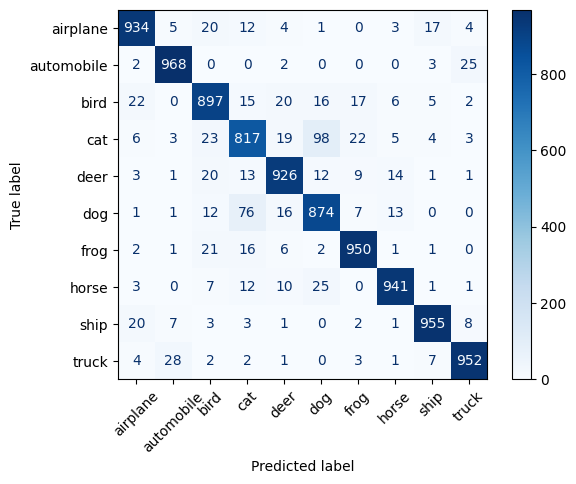

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_loader.dataset.classes)
disp.plot(xticks_rotation=45, cmap='Blues')
plt.show()


In [13]:
from sklearn.metrics import classification_report
print(classification_report(all_labels, all_preds, target_names=test_loader.dataset.classes))


              precision    recall  f1-score   support

    airplane       0.94      0.93      0.94      1000
  automobile       0.95      0.97      0.96      1000
        bird       0.89      0.90      0.89      1000
         cat       0.85      0.82      0.83      1000
        deer       0.92      0.93      0.92      1000
         dog       0.85      0.87      0.86      1000
        frog       0.94      0.95      0.95      1000
       horse       0.96      0.94      0.95      1000
        ship       0.96      0.95      0.96      1000
       truck       0.96      0.95      0.95      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



## Visualize misclassified images

Total misclassified samples: 786


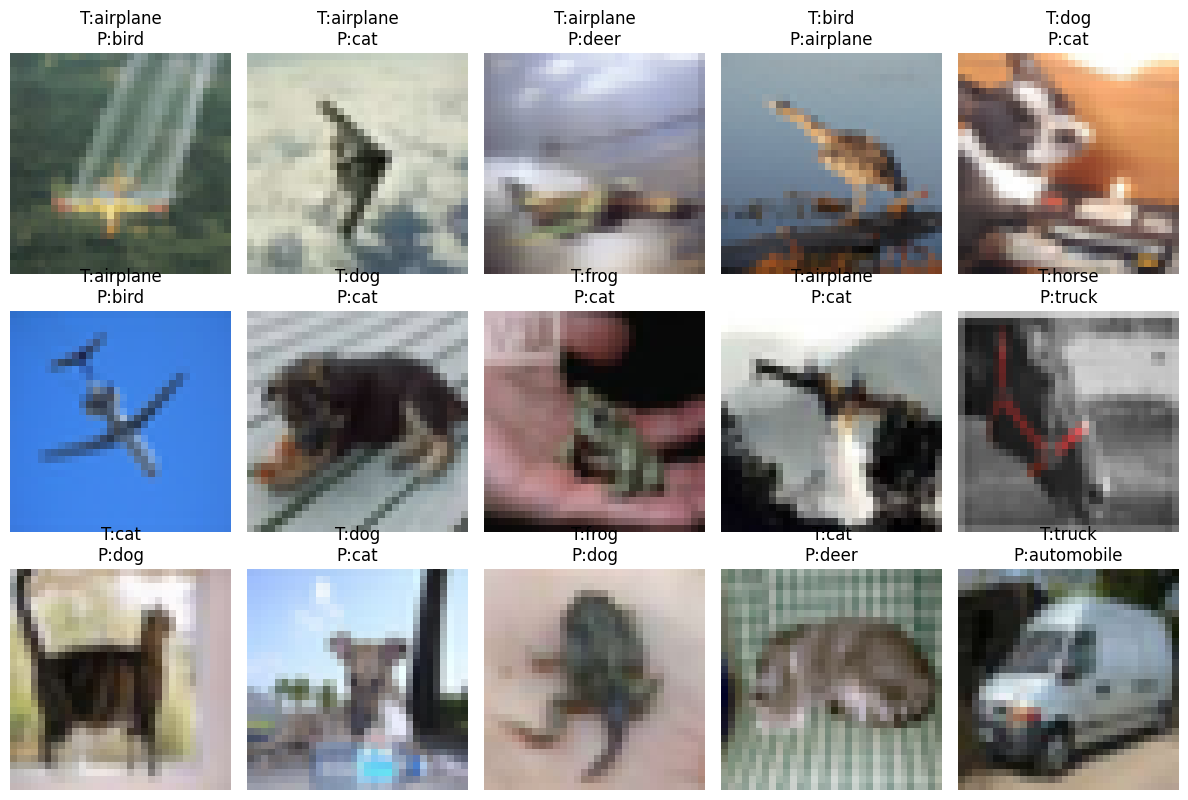

In [15]:
import random
import matplotlib.pyplot as plt

# Get misclassified indices
misclassified_idx = [i for i in range(len(all_labels)) if all_preds[i] != all_labels[i]]

print(f"Total misclassified samples: {len(misclassified_idx)}")

# Randomly select up to 15 misclassified examples
n_show = min(15, len(misclassified_idx))
sample_idx = random.sample(misclassified_idx, n_show)

# Plot
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
for ax, idx in zip(axes.flat, sample_idx):
    img = test_loader.dataset.data[idx]
    true_label = all_labels[idx]
    pred_label = all_preds[idx]
    ax.imshow(img)
    ax.set_title(f"T:{test_loader.dataset.classes[true_label]}\nP:{test_loader.dataset.classes[pred_label]}")
    ax.axis("off")

# If fewer than 15 misclassified, hide unused subplots
for ax in axes.flat[len(sample_idx):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


# Transfer learning


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as T
from torchvision import models
from torch.utils.data import DataLoader
import os

# -------------------------
# 1. Config
# -------------------------
BATCH_SIZE = 64
EPOCHS = 10
LR = 0.001
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

# -------------------------
# 2. Data Transform
# -------------------------
# MobileNetV2 also expects 224x224 RGB images from its ImageNet pretraining
transform_train = T.Compose([
    T.Resize(224),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

transform_test = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# ========================= THE CHANGE (FIXED) =========================
# 3. Load Pretrained MobileNetV2 and set up for transfer learning
# ====================================================================
model = models.mobilenet_v2(pretrained=True)

# Freeze all layers first
for param in model.parameters():
    param.requires_grad = False

# Unfreeze BatchNorm layers to allow them to learn the new dataset's statistics
for module in model.modules():
    if isinstance(module, nn.BatchNorm2d):
        module.requires_grad = True
        # It's also common to unfreeze the parameters of BatchNorm
        for param in module.parameters():
            param.requires_grad = True


# Replace the classifier head
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 10) # CIFAR-10 has 10 classes
)

model = model.to(DEVICE)

# -------------------------
# 4. Loss & Optimizer
# -------------------------
criterion = nn.CrossEntropyLoss()

# We need to collect all parameters that require gradients
params_to_update = []
for param in model.parameters():
    if param.requires_grad:
        params_to_update.append(param)

optimizer = optim.Adam(params_to_update, lr=LR)
# -------------------------
# 5. Training Loop
# -------------------------
print("Starting training with MobileNetV2...")
for epoch in range(EPOCHS):
    model.train()
    running_loss, total, correct = 0.0, 0, 0

    for i, (imgs, labels) in enumerate(trainloader):
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()
        
        # Optional: Print progress within an epoch
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{EPOCHS}], Step [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}')


    acc = 100 * correct / total
    print(f"Epoch [{epoch+1}/{EPOCHS}] Summary | Loss: {running_loss/len(trainloader):.4f} | Train Acc: {acc:.2f}%")

# -------------------------
# 6. Evaluation
# -------------------------
print("\nEvaluating on test set...")
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for imgs, labels in testloader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

print(f"\n✅ Test Accuracy: {100 * correct / total:.2f}%")
print(f"❌ Misclassified Samples: {total - correct} out of {total}")

# -------------------------
# 7. Save Model
# -------------------------
MODEL_DIR = "checkpoints"
if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)
torch.save(model.state_dict(), os.path.join(MODEL_DIR, "mobilenet_cifar10.pth"))
print(f"✅ Model saved to {os.path.join(MODEL_DIR, 'mobilenet_cifar10.pth')}")

Using device: cpu
Starting training with MobileNetV2...
Epoch [1/10], Step [100/782], Loss: 0.4899
Epoch [1/10], Step [200/782], Loss: 0.3490
Epoch [1/10], Step [300/782], Loss: 0.3571
Epoch [1/10], Step [400/782], Loss: 0.2936
Epoch [1/10], Step [500/782], Loss: 0.2741
Epoch [1/10], Step [600/782], Loss: 0.2318
Epoch [1/10], Step [700/782], Loss: 0.2287
Epoch [1/10] Summary | Loss: 0.4072 | Train Acc: 86.23%
Epoch [2/10], Step [100/782], Loss: 0.1346
Epoch [2/10], Step [200/782], Loss: 0.2021
Epoch [2/10], Step [300/782], Loss: 0.0944
Epoch [2/10], Step [400/782], Loss: 0.2889
Epoch [2/10], Step [500/782], Loss: 0.3445
Epoch [2/10], Step [600/782], Loss: 0.2735
Epoch [2/10], Step [700/782], Loss: 0.1686
Epoch [2/10] Summary | Loss: 0.2372 | Train Acc: 91.74%
Epoch [3/10], Step [100/782], Loss: 0.3793
Epoch [3/10], Step [200/782], Loss: 0.1993
Epoch [3/10], Step [300/782], Loss: 0.2778
Epoch [3/10], Step [400/782], Loss: 0.1872
Epoch [3/10], Step [500/782], Loss: 0.1907
Epoch [3/10], S

Using device: cpu
Loading model from: checkpoints\mobilenet_cifar10.pth

Evaluating on test set to find misclassified samples...

✅ Final Test Accuracy from loaded model: 93.24%
❌ Found 676 misclassified samples out of 10000

Visualizing some misclassified samples...


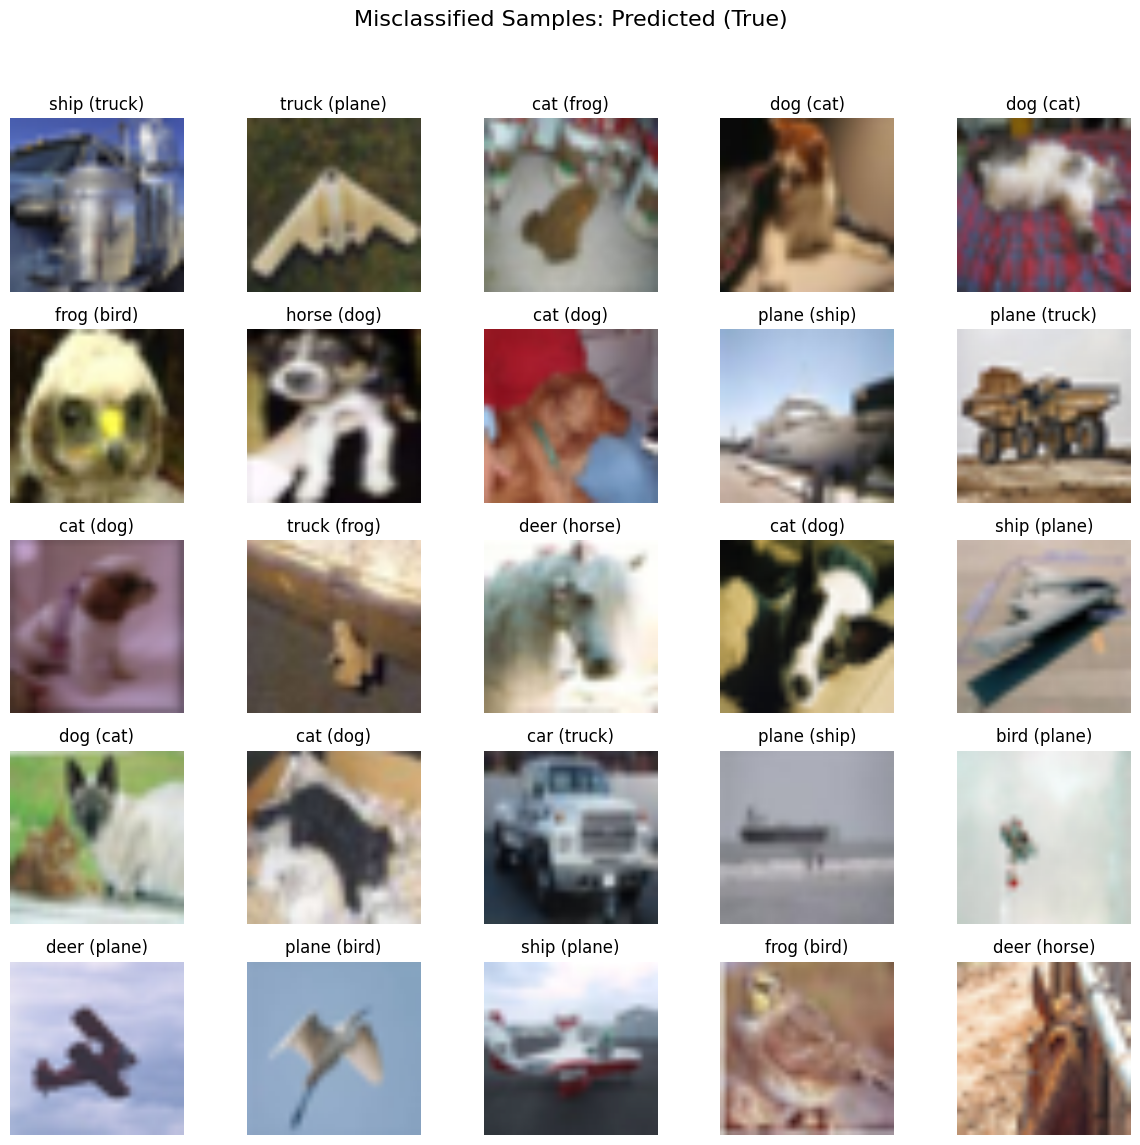

In [2]:
"""
Script to load a trained MobileNetV2 model for CIFAR-10,
evaluate it on the test set, and visualize the images it misclassifies.
"""
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
from torchvision import models
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import numpy as np

# -------------------------
# 1. Config
# -------------------------
BATCH_SIZE = 64
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = os.path.join("checkpoints", "mobilenet_cifar10.pth")
print(f"Using device: {DEVICE}")
print(f"Loading model from: {MODEL_PATH}")

# -------------------------
# 2. Data Transform & Loader
# --- PHẢI GIỐNG HỆT NHƯ LÚC HUẤN LUYỆN ---
# -------------------------
transform_test = T.Compose([
    T.Resize(224),
    T.ToTensor(),
    T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# -------------------------
# 3. Recreate Model Architecture and Load Weights
# -------------------------
# Bước 1: Tạo một "bộ khung" kiến trúc giống hệt mô hình đã lưu.
# Dùng pretrained=False vì chúng ta sẽ load trọng số của chính mình, không cần load lại từ ImageNet.
model = models.mobilenet_v2(pretrained=False) 

# Bước 2: Thay đổi lớp classifier cuối cùng cho khớp.
num_features = model.classifier[1].in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(num_features, 10) # CIFAR-10 có 10 lớp
)

# Bước 3: Tải các trọng số đã được huấn luyện vào "bộ khung"
model.load_state_dict(torch.load(MODEL_PATH, map_location=DEVICE))
model = model.to(DEVICE)

# --- CỰC KỲ QUAN TRỌNG: Chuyển sang chế độ đánh giá ---
model.eval() 

# -------------------------
# 4. Evaluation & Storing Misclassifieds
# -------------------------
print("\nEvaluating on test set to find misclassified samples...")
correct, total = 0, 0
misclassified_samples = []

with torch.no_grad():
    for imgs, labels in testloader:
        imgs, labels = imgs.to(DEVICE), labels.to(DEVICE)
        outputs = model(imgs)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += preds.eq(labels).sum().item()

        # ========================= PHẦN SỬA LỖI =========================
        misclassified_idx = (preds != labels).nonzero().squeeze()
        
        # Xử lý trường hợp chỉ có MỘT mẫu sai (tensor 0-d)
        if misclassified_idx.dim() == 0:
            # Nếu nó là 0-d, biến nó thành một list chứa chính nó để có thể lặp
            misclassified_idx = [misclassified_idx]

        for idx in misclassified_idx:
            # Chỉ lưu 25 mẫu đầu tiên để vẽ đồ thị
            if len(misclassified_samples) < 25: 
                misclassified_samples.append((imgs[idx], preds[idx], labels[idx]))
        # =================================================================

print(f"\n✅ Final Test Accuracy from loaded model: {100 * correct / total:.2f}%")
print(f"❌ Found {total - correct} misclassified samples out of {total}")
# -------------------------
# 5. Visualize Misclassified Images
# -------------------------

# Định nghĩa tên các lớp của CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Hàm để giải-chuẩn hóa và hiển thị ảnh
def unnormalize(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).to(DEVICE)
    std = torch.tensor([0.229, 0.224, 0.225]).to(DEVICE)
    mean = mean.view(3, 1, 1)
    std = std.view(3, 1, 1)
    img_tensor = img_tensor * std + mean
    return img_tensor

if misclassified_samples:
    print("\nVisualizing some misclassified samples...")
    fig, axes = plt.subplots(5, 5, figsize=(12, 12))
    fig.suptitle("Misclassified Samples: Predicted (True)", fontsize=16)

    for i, (img, pred, true) in enumerate(misclassified_samples):
        img = unnormalize(img)
        img_np = img.cpu().numpy()
        img_np = np.transpose(img_np, (1, 2, 0))
        
        ax = axes[i // 5, i % 5]
        ax.imshow(np.clip(img_np, 0, 1)) # Dùng clip để đảm bảo giá trị pixel nằm trong khoảng [0,1]
        
        pred_class = classes[pred.item()]
        true_class = classes[true.item()]
        ax.set_title(f"{pred_class} ({true_class})")
        ax.axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
else:
    print("\nNo misclassified samples to show!")